# Homework

Apply `BatchNorm`, `Dropout` and `Residual` on MLP networks for CIFAR-10 classification.

For BatchNorm and Dropout, design models with `BatchNorm Layer`, `Dropout Layer` and both the layers. Compare the results with a plain MLP, and with each other.

For Residual, design a simple `Redisual Block` based on a deeper MLP. Compare the results and see whether adding residual works.

Follow the pipeline in your Homework 2 to finish model designing, training and testing.

### Step 1: Load Dataset

In [106]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

# 设置 matplotlib 显示格式
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # 设置默认图像大小
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# CIFAR-10 数据集的下载和加载
transform = transforms.Compose(
    [transforms.ToTensor(),  # 转换为 Tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]  # 归一化
)

In [107]:
from torch.utils.data import Dataset, DataLoader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
class OursDatasetwithTransforms(Dataset):
    def __init__(self, data, labels, transforms):
        """
        初始化数据集
        data: 输入数据，例如一个 NumPy 数组或 PyTorch 张量
        labels: 对应的标签
        """
        self.data = data
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        # 每个Dataset都必须写，返回数据集的大小
        return len(self.data)

    def __getitem__(self, idx):
        # 每个Dataset都必须写，获取指定索引idx的数据和标签
        sample = self.data[idx]
        label = self.labels[idx]
        sample = self.transforms(sample)
        return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
        
transform = transforms.Compose(
    [transforms.ToTensor(),  # [0, 255], PIL Image / ndarray --> [0, 1], torch.tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]  # 归一化, (input[channel] - mean[channel]) / std[channel]
)
traindata = trainset.data[:5000]
trainlabels = trainset.targets[:5000]
testdata = testset.data[:500]
testlabels = testset.targets[:500]

# 初始化自定义数据集
trainset = OursDatasetwithTransforms(traindata, trainlabels, transform)
testset = OursDatasetwithTransforms(testdata, testlabels, transform)
trainloader = DataLoader(trainset, batch_size=256, shuffle=False, drop_last=False)
testloader = DataLoader(testset, batch_size=256, shuffle=False, drop_last=False)

Files already downloaded and verified
Files already downloaded and verified


In [108]:
# Helper functions for plotting the loss values
from typing import List
def plot_loss(num_epochs: int, train_losses: List, test_losses: List) -> None:
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Testing Loss', marker='x')
    plt.title('Training and Testing Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

### Step 2: Design a 3-Layer MLP with BatchNorm and Dropout

In [109]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Here is the simple version of A 3-layer MLP
class SimpleMLP(nn.Module):
    def __init__(self, input_size=32*32*3, hidden_size=512):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # For CIFAR-10, input size is 32x32x3
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 10)  # Output size is 10 classes for CIFAR-10
    
    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)  # Flatten the image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Implementation of MLP with BatchNorm only
# Use nn.BatchNorm1d
class MLPWithBatchNorm(nn.Module):
    def __init__(self, input_size=32*32*3, hidden_size=512):
        # your code here
        super(MLPWithBatchNorm, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.batchnorm1 = nn.BatchNorm1d(hidden_size)  # BatchNorm layer1
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.batchnorm2 = nn.BatchNorm1d(hidden_size)  # BatchNorm layer2
        self.fc3 = nn.Linear(hidden_size, 10)
        

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.fc1(x)
        x = self.batchnorm1(x)  # use BatchNorm
        x = F.relu(x)
        x = self.fc2(x)
        x = self.batchnorm2(x)  # use BatchNorm
        x = F.relu(x)
        x = self.fc3(x)
        return x

# Implementation of MLP with Dropout only 
# Use nn.Dropout
class MLPWithDropout(nn.Module):
    def __init__(self, input_size=32*32*3, hidden_size=512, dropout_prob=0.5):
        # your code here
        super(MLPWithDropout, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 10)
        self.dropout = nn.Dropout(p=dropout_prob)  # Dropout layer
    
    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # use Dropout
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  # use Dropout
        x = self.fc3(x)
        return x
        
    
# Implementation of MLP with both BatchNorm and Dropout
# Use nn.BatchNorm1d and nn.Dropout  
class MLPWithBatchNormDropout(nn.Module):
    def __init__(self, input_size=32*32*3, hidden_size=512, dropout_prob=0.5):
        # your code here
        super(MLPWithBatchNormDropout, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.batchnorm1 = nn.BatchNorm1d(hidden_size)  # BatchNorm layer1
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.batchnorm2 = nn.BatchNorm1d(hidden_size)  # BatchNorm layer2
        self.fc3 = nn.Linear(hidden_size, 10)
        self.dropout = nn.Dropout(p=dropout_prob)  # Dropout layer

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.fc1(x)
        x = self.batchnorm1(x)  # use BatchNorm
        x = F.relu(x)
        x = self.dropout(x)  # use Dropout
        x = self.fc2(x)
        x = self.batchnorm2(x)  # use BatchNorm
        x = F.relu(x)
        x = self.dropout(x)  # use Dropout
        x = self.fc3(x)
        return x
   

In [110]:
# Training and Testing Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, train_loader):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

def test(model, test_loader):
    criterion = nn.CrossEntropyLoss()
    
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    test_loss = running_loss / len(test_loader)
    test_acc = 100. * correct / total
    return test_loss, test_acc

### Step 3: Train the networks

In [111]:
# Hyper parameters
num_epochs = 10

In [112]:
# Train SimpleMLP
# your code here
def train_with_test(model, trainloader, testloader, num_epochs):
    train_loss_history = []
    test_loss_history = []
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, trainloader)
        test_loss, test_acc = test(model, testloader)
        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%,',
            f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc}%')
        
    return train_loss_history, test_loss_history
    
model_simple = SimpleMLP().to(device)
train_loss, test_loss = train_with_test(model_simple, trainloader, testloader, num_epochs)

C:\Users\charles0618\AppData\Local\Temp\ipykernel_33952\2358819985.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Epoch 1, Train Loss: 1.9522, Train Acc: 30.34%, Test Loss: 1.8221, Test Acc: 36.4%
Epoch 2, Train Loss: 1.7213, Train Acc: 38.86%, Test Loss: 1.7224, Test Acc: 37.2%
Epoch 3, Train Loss: 1.5806, Train Acc: 44.86%, Test Loss: 1.7170, Test Acc: 38.2%
Epoch 4, Train Loss: 1.4685, Train Acc: 49.32%, Test Loss: 1.7136, Test Acc: 35.6%
Epoch 5, Train Loss: 1.3540, Train Acc: 54.46%, Test Loss: 1.7037, Test Acc: 38.2%
Epoch 6, Train Loss: 1.2344, Train Acc: 59.28%, Test Loss: 1.7734, Test Acc: 35.8%
Epoch 7, Train Loss: 1.1252, Train Acc: 63.92%, Test Loss: 1.8023, Test Acc: 36.2%
Epoch 8, Train Loss: 1.0327, Train Acc: 67.72%, Test Loss: 1.8841, Test Acc: 34.4%
Epoch 9, Train Loss: 1.0080, Train Acc: 68.40%, Test Loss: 1.9518, Test Acc: 37.4%
Epoch 10, Train Loss: 0.9466, Train Acc: 70.28%, Test Loss: 2.0254, Test Acc: 39.8%


In [113]:
# Train MLPWithBatchNorm
model_with_BN = MLPWithBatchNorm().to(device)
train_loss, test_loss = train_with_test(model_with_BN, trainloader, testloader, num_epochs)

C:\Users\charles0618\AppData\Local\Temp\ipykernel_33952\2358819985.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Epoch 1, Train Loss: 1.8774, Train Acc: 32.36%, Test Loss: 1.7762, Test Acc: 38.2%
Epoch 2, Train Loss: 1.6526, Train Acc: 41.04%, Test Loss: 1.7047, Test Acc: 37.4%
Epoch 3, Train Loss: 1.4715, Train Acc: 48.74%, Test Loss: 1.6826, Test Acc: 39.4%
Epoch 4, Train Loss: 1.3045, Train Acc: 55.86%, Test Loss: 1.6917, Test Acc: 38.8%
Epoch 5, Train Loss: 1.1418, Train Acc: 62.26%, Test Loss: 1.7029, Test Acc: 40.8%
Epoch 6, Train Loss: 1.0009, Train Acc: 67.92%, Test Loss: 1.7419, Test Acc: 40.0%
Epoch 7, Train Loss: 0.8950, Train Acc: 72.44%, Test Loss: 1.8669, Test Acc: 40.2%
Epoch 8, Train Loss: 0.8338, Train Acc: 74.08%, Test Loss: 1.9507, Test Acc: 37.8%
Epoch 9, Train Loss: 0.7686, Train Acc: 75.82%, Test Loss: 2.0731, Test Acc: 38.0%
Epoch 10, Train Loss: 0.6775, Train Acc: 78.94%, Test Loss: 2.1023, Test Acc: 37.6%


In [114]:
# Training MLPWithDropout
# your code here
model_with_Dropout = MLPWithDropout().to(device)
train_loss, test_loss = train_with_test(model_with_Dropout, trainloader, testloader, num_epochs)

C:\Users\charles0618\AppData\Local\Temp\ipykernel_33952\2358819985.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Epoch 1, Train Loss: 2.0698, Train Acc: 25.10%, Test Loss: 1.8485, Test Acc: 32.0%
Epoch 2, Train Loss: 1.8954, Train Acc: 32.48%, Test Loss: 1.7704, Test Acc: 35.6%
Epoch 3, Train Loss: 1.8021, Train Acc: 35.78%, Test Loss: 1.7236, Test Acc: 37.6%
Epoch 4, Train Loss: 1.7432, Train Acc: 38.42%, Test Loss: 1.7074, Test Acc: 39.2%
Epoch 5, Train Loss: 1.7016, Train Acc: 39.58%, Test Loss: 1.6890, Test Acc: 41.2%
Epoch 6, Train Loss: 1.6625, Train Acc: 41.44%, Test Loss: 1.6626, Test Acc: 39.8%
Epoch 7, Train Loss: 1.6252, Train Acc: 42.96%, Test Loss: 1.6572, Test Acc: 38.4%
Epoch 8, Train Loss: 1.5876, Train Acc: 44.62%, Test Loss: 1.6594, Test Acc: 39.4%
Epoch 9, Train Loss: 1.5545, Train Acc: 45.80%, Test Loss: 1.6570, Test Acc: 40.0%
Epoch 10, Train Loss: 1.5318, Train Acc: 46.92%, Test Loss: 1.6410, Test Acc: 40.6%


In [115]:
# Training MLPWithBatchNormDropout
# your code here
model_with_BN_Dropout = MLPWithBatchNormDropout().to(device)
train_loss, test_loss = train_with_test(model_with_BN_Dropout, trainloader, testloader, num_epochs)

C:\Users\charles0618\AppData\Local\Temp\ipykernel_33952\2358819985.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Epoch 1, Train Loss: 2.0823, Train Acc: 24.94%, Test Loss: 1.8495, Test Acc: 33.8%
Epoch 2, Train Loss: 1.8627, Train Acc: 33.44%, Test Loss: 1.7555, Test Acc: 37.0%
Epoch 3, Train Loss: 1.7542, Train Acc: 36.94%, Test Loss: 1.7072, Test Acc: 38.8%
Epoch 4, Train Loss: 1.6804, Train Acc: 40.56%, Test Loss: 1.6709, Test Acc: 38.4%
Epoch 5, Train Loss: 1.6144, Train Acc: 42.34%, Test Loss: 1.6435, Test Acc: 38.6%
Epoch 6, Train Loss: 1.5799, Train Acc: 43.94%, Test Loss: 1.6327, Test Acc: 39.0%
Epoch 7, Train Loss: 1.5092, Train Acc: 46.20%, Test Loss: 1.6419, Test Acc: 39.6%
Epoch 8, Train Loss: 1.4938, Train Acc: 46.72%, Test Loss: 1.6243, Test Acc: 38.8%
Epoch 9, Train Loss: 1.4468, Train Acc: 48.64%, Test Loss: 1.6201, Test Acc: 40.2%
Epoch 10, Train Loss: 1.4231, Train Acc: 51.48%, Test Loss: 1.6187, Test Acc: 40.0%


#### Question: Analysis the results and find out whether any of the above techniques is useful for training this MLP for CIFAR-10 classification. Explain why/how they work?

#### Your answer:

Regard `SimpleMLP()` as the baseline, it can be seen from the training output above that the three advanced models did   improve the classification result.

- As for `MLPWithBatchNorm()` , 2 `BatchNorm` layers are incorporated. By standardizing the output of the hidden layer, training was accelerated and the model stability can be improved. We can see that after 10 epochs of training, Train loss was lower and Train accuracy was higher compared to the `SimpleMLP()` .
- As for `MLPWithDropout()` , `Dropout` is used after activation. By randomly discarding some neurons, overfitting can be effectively reduced and the model's generalization ability can be increased. We can see that the Train accuracy was obviously lower than `SimpleMLP()` , indicating less overfitting. Also, the Test accuracy was higher, slightly though.
- As for `MLPWithBatchNormDropout()` , it combines the advantages of `MLPWithBatchNorm()` and `MLPWithBatchNorm()` , so its training result showed a better generalization ability on Test dataloader and a lower overfitting level on Train dataloader.

### Step4: Design a MLP that has deeper layers with Residual Blocks

In [116]:
# A deeper MLP with 50 layers
class DeepMLP(nn.Module):
    def __init__(self, input_size=32*32*3, num_classes=10, hidden_size=512, num_layers=50):
        super(DeepMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        
        # Stack multiple hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_size, hidden_size) for _ in range(num_layers)
        ])
        self.bn_layers = nn.ModuleList([
            nn.BatchNorm1d(hidden_size) for _ in range(num_layers)
        ])
        
        self.fc_out = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        
        x = x.view(-1, 32*32*3)
        x = F.relu(self.bn1(self.fc1(x)))

        # Pass through deep hidden layers
        for i in range(len(self.hidden_layers)):
            x = F.relu(self.bn_layers[i](self.hidden_layers[i](x)))
        
        # Output layer for classification
        x = self.fc_out(x)
        
        return x

In [117]:
# Design a residual block
# input -> Linear -> batchnorm -> activation -> dropout -> Linear -> batchnorm -> skip connection -> activation -> output
class ResidualMLPBlock(nn.Module):
    def __init__(self,  input_size, hidden_size, dropout_prob=0.5):
        # your code here
        super(ResidualMLPBlock, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        output = self.fc1(x)  # Linear
        output = self.bn1(output)  # batchnorm
        output = F.relu(output)  # activation
        output = self.dropout(output)  # dropout

        output = self.fc2(output)  # Linear
        output = self.bn2(output)  # batchnorm

        output += x  # skip connection
        output = F.relu(output)  # activation

        return output 
        
        

# Design MLP with residual blocks
# Use nn.ModuleList 
# input -> Linear -> batchnorm -> activation -> residual layers -> classifacation layer
class DeepResidualMLP(nn.Module):
    def __init__(self, input_size=32*32*3, num_classes=10, hidden_size=512, num_layers=51, dropout_prob=0.5):
        # your code here
        super(DeepResidualMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        
        # residual layers
        self.residual_layers = nn.ModuleList([
            ResidualMLPBlock(hidden_size, hidden_size) for _ in range(num_layers)
        ])

        self.fc_out = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # input -> Linear -> batchnorm -> activation 
        x = x.view(-1, 32*32*3)
        x = F.relu(self.bn1(self.fc1(x)))

        # residual layers
        for layer in self.residual_layers:
            x = layer(x)

        # classifacation layer
        x = self.fc_out(x)
        return x

C:\Users\charles0618\AppData\Local\Temp\ipykernel_33952\2358819985.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Epoch 1, Train Loss: 2.3527, Train Acc: 10.64%, Test Loss: 2.3091, Test Acc: 8.0%
Epoch 2, Train Loss: 2.3101, Train Acc: 11.56%, Test Loss: 47.2756, Test Acc: 13.4%
Epoch 3, Train Loss: 2.3189, Train Acc: 11.20%, Test Loss: 135.5827, Test Acc: 11.2%
Epoch 4, Train Loss: 2.3242, Train Acc: 10.26%, Test Loss: 10.8651, Test Acc: 14.2%
Epoch 5, Train Loss: 2.3455, Train Acc: 10.30%, Test Loss: 2.6198, Test Acc: 10.8%
Epoch 6, Train Loss: 2.3292, Train Acc: 9.76%, Test Loss: 2.3283, Test Acc: 9.8%
Epoch 7, Train Loss: 2.3177, Train Acc: 10.08%, Test Loss: 56.1685, Test Acc: 14.6%
Epoch 8, Train Loss: 2.3146, Train Acc: 10.80%, Test Loss: 3.1847, Test Acc: 10.8%
Epoch 9, Train Loss: 2.2889, Train Acc: 11.72%, Test Loss: 4.0245, Test Acc: 12.2%
Epoch 10, Train Loss: 2.2583, Train Acc: 12.38%, Test Loss: 2.8730, Test Acc: 13.6%


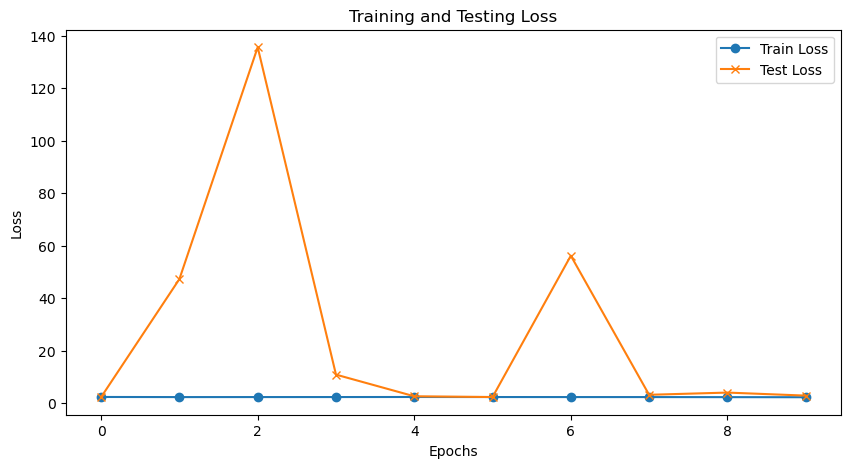

In [123]:
# Training DeepMLP
# your code here
model_deepMLP = DeepMLP().to(device)
train_loss, test_loss = train_with_test(model_deepMLP, trainloader, testloader, 10)

# Save the losses during training and testing and plot them using plot_loss()
# your code here
def plot_loss(train_loss, test_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Train Loss', marker='o')
    plt.plot(test_loss, label='Test Loss', marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Testing Loss')
    plt.show()

plot_loss(train_loss, test_loss)

C:\Users\charles0618\AppData\Local\Temp\ipykernel_33952\2358819985.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Epoch 1, Train Loss: 4.7596, Train Acc: 13.68%, Test Loss: 11.0384, Test Acc: 21.8%
Epoch 2, Train Loss: 3.8588, Train Acc: 17.94%, Test Loss: 11.5428, Test Acc: 22.2%
Epoch 3, Train Loss: 3.1002, Train Acc: 20.88%, Test Loss: 3.2698, Test Acc: 27.6%
Epoch 4, Train Loss: 2.7455, Train Acc: 23.72%, Test Loss: 2.3542, Test Acc: 29.8%
Epoch 5, Train Loss: 2.5435, Train Acc: 27.08%, Test Loss: 6.0017, Test Acc: 32.2%
Epoch 6, Train Loss: 2.3280, Train Acc: 29.32%, Test Loss: 3.2336, Test Acc: 26.0%
Epoch 7, Train Loss: 2.1273, Train Acc: 32.90%, Test Loss: 2.0118, Test Acc: 31.6%
Epoch 8, Train Loss: 1.9725, Train Acc: 33.94%, Test Loss: 1.9992, Test Acc: 33.6%
Epoch 9, Train Loss: 1.9003, Train Acc: 37.80%, Test Loss: 1.8290, Test Acc: 35.4%
Epoch 10, Train Loss: 1.7722, Train Acc: 41.32%, Test Loss: 1.7970, Test Acc: 37.6%


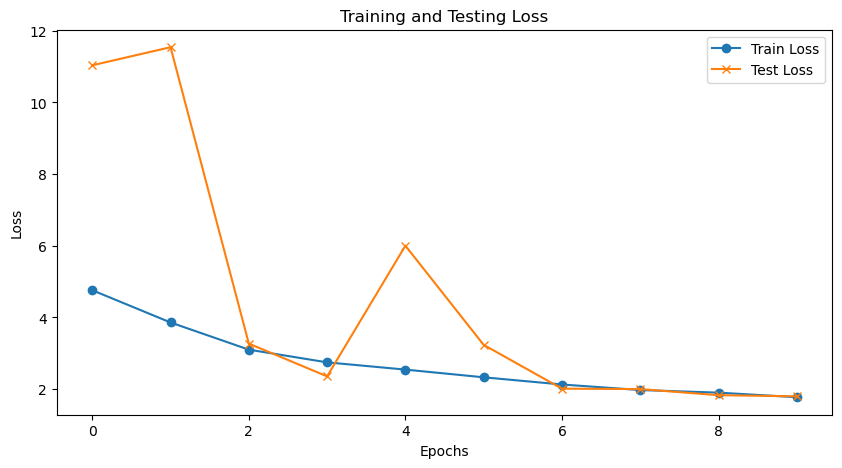

In [127]:
# Training DeepResidualMLP
# your code here
model_ResMLP = DeepResidualMLP().to(device)
train_loss, test_loss = train_with_test(model_ResMLP, trainloader, testloader, 10)

# Save the losses during training and testing and plot them using plot_loss()
# your code here
plot_loss(train_loss, test_loss)

#### Bonus: Try to see the gradient flow when training the above networks

In [120]:
def compute_gradient_norm(model):
    total_norm = 0.0
    for param in model.parameters():
        if param.grad is not None:
            total_norm += param.grad.data.norm(2).item() ** 2
    return total_norm ** 0.5


def train_record_gradient(model, train_loader):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    grad_norms = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        # caculate gradient norm (L2)
        grad_norm = compute_gradient_norm(model)
        grad_norms.append(grad_norm)

        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        avg_grad_norm = sum(grad_norms) / len(grad_norms) if len(grad_norms) > 0 else 0
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc, avg_grad_norm

In [121]:
num_epochs = 100
model = DeepResidualMLP().to(device)

for epoch in range(num_epochs):
    model.train()
    train_loss, train_acc, avg_grad_norm = train_record_gradient(model, trainloader)
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Average Gradient Norm: {avg_grad_norm:.4f}')

C:\Users\charles0618\AppData\Local\Temp\ipykernel_33952\2358819985.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Epoch [1/100]
Train Loss: 4.6308, Train Acc: 12.70%
Average Gradient Norm: 49.9393
Epoch [2/100]
Train Loss: 4.5947, Train Acc: 16.84%
Average Gradient Norm: 33.9292
Epoch [3/100]
Train Loss: 2.9833, Train Acc: 21.56%
Average Gradient Norm: 22.2593
Epoch [4/100]
Train Loss: 2.6034, Train Acc: 24.66%
Average Gradient Norm: 21.0372
Epoch [5/100]
Train Loss: 2.3809, Train Acc: 29.04%
Average Gradient Norm: 15.6203
Epoch [6/100]
Train Loss: 2.3052, Train Acc: 32.00%
Average Gradient Norm: 16.0209
Epoch [7/100]
Train Loss: 2.1051, Train Acc: 34.30%
Average Gradient Norm: 14.0712
Epoch [8/100]
Train Loss: 2.0489, Train Acc: 35.88%
Average Gradient Norm: 13.6915
Epoch [9/100]
Train Loss: 1.8684, Train Acc: 38.90%
Average Gradient Norm: 10.4192
Epoch [10/100]
Train Loss: 1.7711, Train Acc: 41.66%
Average Gradient Norm: 9.0753
Epoch [11/100]
Train Loss: 1.6911, Train Acc: 44.80%
Average Gradient Norm: 9.7751
Epoch [12/100]
Train Loss: 1.7489, Train Acc: 47.22%
Average Gradient Norm: 8.4153
Epoc